In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)



In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
most_current_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_current_date = str(most_current_date)[2:-3]
print(most_current_date)
year_from_current = str(eval(most_current_date[0:4])-1) + most_current_date[4:]
print(year_from_current)

# Perform a query to retrieve the data and precipitation scores
last_12m_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_from_current).filter(Measurement.date <= most_current_date).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_prcp_df = pd.DataFrame(data=last_12m_prcp)
last_12_prcp_df.set_index("date", inplace=True)
last_12_prcp_df.rename(columns={"prcp": "precipitation"}, inplace=True)
last_12_prcp_df.head()
# Sort the dataframe by date
#last_12_prcp_df = last_12_prcp_df.sort_index(ascending=True)
last_12_prcp_df.sort_index()
last_12_prcp_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
#last_12_prcp_df.plot(title="Precipitation: 8/23/16 - 8/23/17")

2017-08-23
2016-08-23


,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


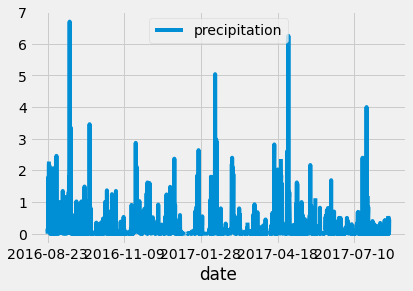

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_prcp_df.plot()
plt.legend(loc=9)
plt.savefig("precipitation_analysis.png")
plt.show()

In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count

(9)

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
observations = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())

for station in observations:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station = observations[0][0]

stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == top_station)
                      
stats_list=list(stats)
print(stats_list)

[(54.0, 85.0, 71.66378066378067)]


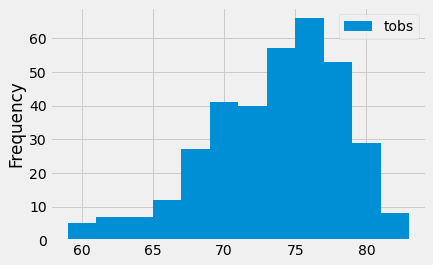

<Figure size 432x288 with 0 Axes>

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.tobs)\
.filter(Measurement.date >= year_from_current)\
.filter(Measurement.date <= most_current_date)\
.filter(Measurement.station == top_station)\

tobs_list = []
for tob in tobs:
    tobs_list.append(tob[0])
    
fig = plt.figure()
plt.hist(tobs_list, bins=12 , label='tobs')
plt.ylabel("Frequency")
plt.legend(loc=1)
plt.show()
plt.savefig("station_observation_analysis.png")

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-04-08'
end_date = '2017-04-19'

prev_year_start = str(eval(start_date[0:4])-1) + start_date[4:]
prev_year_end = str(eval(end_date[0:4])-1) + end_date[4:]

last_year_temp_analysis = calc_temps(prev_year_start, prev_year_end)

tmin = last_year_temp_analysis[0][0]
tmax = last_year_temp_analysis[0][1]
tavg = last_year_temp_analysis[0][2]

print(last_year_temp_analysis)

[(66.0, 73.53424657534246, 80.0)]


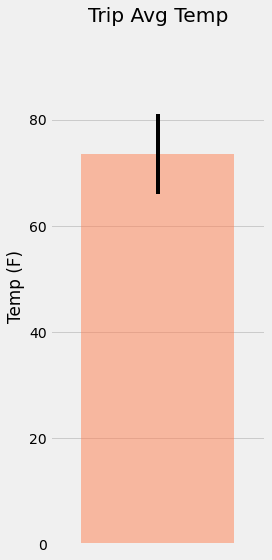

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))

bar= ax.bar(1, tmax, yerr=(tmax-tmin),alpha=0.5, color="coral")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel = "Temp (F)")
ax.margins(.2,.2)
fig.tight_layout()

plt.savefig("temperature_analysis.png")
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = ([Station.station, 
        Station.name, 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= prev_year_start)
                   .filter(Measurement.date <= prev_year_end)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

#convert query object to data frame
stationRainTable = pd.DataFrame(np.array(stationRain))
#rename columns
stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Name", 
                                                    2: "Latitude", 
                                                    3: "Longitude", 4: "Elevation"})

stationRainTable

,Station,Name,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9


In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
startDate = "2019-04-08"
endDate = "2019-04-19"
# Use the start and end date to create a range of dates
startNum = int(startDate[-2:])
endNum = int(endDate[-2:])
tripLength = endNum - startNum + 1
# Stip off the year and save a list of %m-%d strings
startDate = dt.datetime.strptime(startDate, '%Y-%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]

tripNormals = [daily_normals(date) for date in dateList]

tripNormals

[[(66.0, 72.10526315789474, 77.0)],
 [(62.0, 71.6140350877193, 78.0)],
 [(64.0, 71.40350877192982, 79.0)],
 [(65.0, 72.49180327868852, 82.0)],
 [(65.0, 72.22413793103448, 80.0)],
 [(64.0, 71.52542372881356, 79.0)],
 [(65.0, 72.75, 81.0)],
 [(61.0, 71.79310344827586, 79.0)],
 [(62.0, 71.55357142857143, 81.0)],
 [(65.0, 71.93103448275862, 77.0)],
 [(67.0, 72.49152542372882, 77.0)],
 [(65.0, 72.42105263157895, 83.0)]]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tripNormals = [np.array(normal[0]) for normal in tripNormals]

#convert normals list into a data frame
normalsTable = pd.DataFrame(tripNormals)
#add date column
normalsTable["Date"] = dateList
#set index and rename columns
normalsTable = normalsTable.set_index("Date")
normalsTable = normalsTable.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normalsTable

,Low Temp,Avg Temp,High Temp
Date,,,
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0
04-14,65.0,72.750000,81.0
04-15,61.0,71.793103,79.0
04-16,62.0,71.553571,81.0


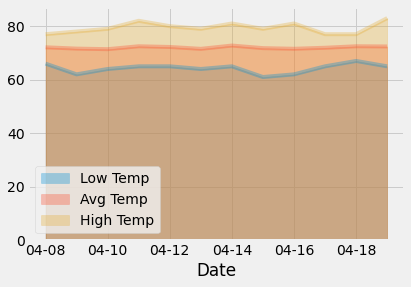

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
normalsTable.plot.area(stacked=False, alpha=.333)